In [199]:
import numpy as np
import matplotlib.pyplot as plt
import numba 
from numba import jit

from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

$$\frac{\partial T}{\partial t} = \alpha^2 \Delta T -\beta (T-T_0)$$
$$\Delta = \frac{\partial^2 }{\partial x^2} +  \frac{\partial^2 }{\partial y^2}$$

$$\frac{\partial T}{\partial t} = \alpha^2 [\frac{\partial^2 T}{\partial x^2} +  \frac{\partial^2 T}{\partial y^2}] -\beta (T-T_0)$$

Boundaries:

$$T(x, y, t)|x^2 + y^2 = r_{beam}^2 = T_{laser}$$

$$T(x, y, t)|x^2 + y^2 \geq r_{beam}^2 = T_{atmosphere}$$

In [200]:
dx_size = 0.125 #mm
dy_size = 0.125 #mm
dt = 0.5
a_sauce = 1.92e-4

gridsize = np.arange(0, 20, dx_size) #mm 
xv, yu = np.meshgrid(gridsize, gridsize)

In [201]:
s = a_sauce * dt / (dx_size ** 2)
s

0.006144

For convergence of computations $ s = \alpha dt/dx^2 << 1/4$

In [202]:
def circle_mask(x_shape, y_shape, x0, y0, r):
    mask = np.zeros((x_shape, y_shape))
    
    for i in range(x_shape):
        for j in range(y_shape):
            if (x0 - i) ** 2 + (y0 - j) ** 2 <= r**2:
                mask[i][j] = 1
                
    return mask.astype(bool)

def circle_on_array(x_shape, y_shape, x0, y0, r):
    mask = np.zeros((x_shape, y_shape))
    
    for i in range(x_shape):
        for j in range(y_shape):
            if (x0 - i) ** 2 + (y0 - j) ** 2 <= r**2:
                mask[i][j] = 1
                
    return mask.astype(int)

In [203]:
initial_tempreature = 25 + 273.15 #Celsicus deg
laser_tempareature  = 70 + 273.16

temperature = np.zeros((160, 160)) + initial_tempreature
laser_mask = circle_mask(160, 160, 80, 80, 1/dx_size) #1 is for 1mm
sauce_mask = circle_on_array(160, 160, 80, 80, 5/dx_size)  - circle_on_array(160, 160, 80, 80, 1/dx_size)  #5 is for 5mm
sauce_mask = sauce_mask.astype(bool)

temperature[laser_mask] = laser_tempareature

### Plot of laser beam in image center

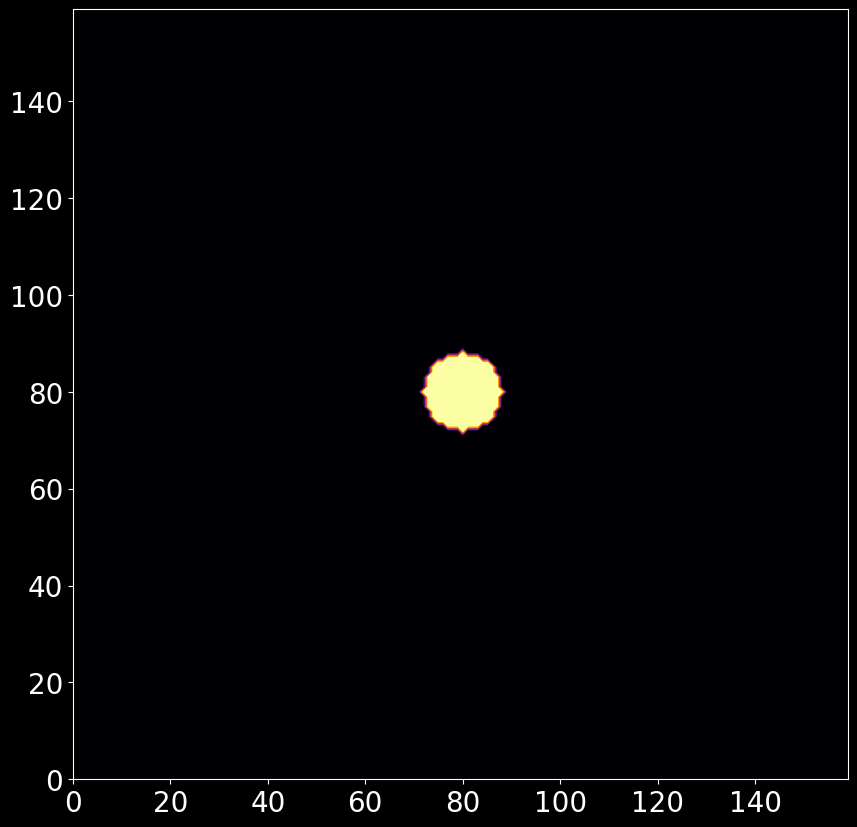

In [417]:
plt.figure(figsize=(10, 10))
plt.contourf(temperature, vmin = initial_tempreature, vmax=laser_tempareature, cmap='inferno')

### Plot of sauce mask

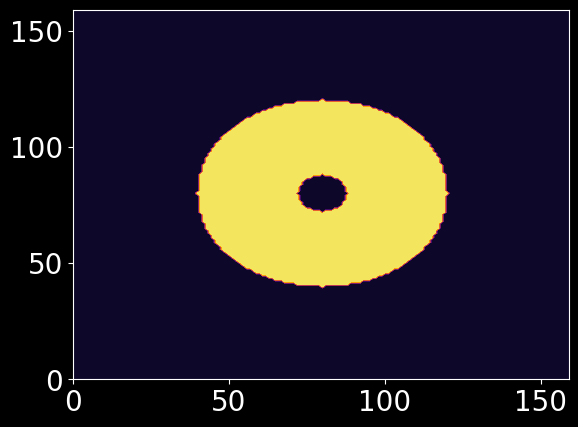

In [205]:
plt.contourf(sauce_mask, cmap='inferno')

In [206]:
times = 180000
frame_iteration = 10
times_snapshot = int(times / frame_iteration)

In [207]:
heat_frames = np.zeros([times_snapshot, 160, 160])
heat_frames[0] = temperature

## Diffusive model
For simple equation, such as: 
$$\frac{\partial T}{\partial t} = \alpha^2 \Delta T =  \alpha^2 [\frac{\partial^2 T}{\partial x^2} +  \frac{\partial^2 T}{\partial y^2}]  $$

solution can be derived with easy grid based Eulier method: 

$$\frac{\partial T}{\partial t} = \alpha^2 \Delta T =  \alpha^2 [\frac{T_{i+1, j}^{(m)} - 2T_{i, j}^{(m)} + T_{i-1, j}^{(m)}}{\Delta x^2} +  \frac{T_{i, j+1}^{(m)} - 2T_{i, j}^{(m)} + T_{i, j-1}^{(m)}}{\Delta y^2}] =  \frac{T_{i, j}^{(m+1)} - T_{i, j}^{(m)}}{\Delta t}$$

In [208]:
@numba.jit("f8[:,:,:](f8[:,:,:], b1[:,:])", nopython=True, nogil=True)
def solve_heat(heatmap, sauce_mask):
    current_state  = heatmap[0].copy()
    x_size, y_size = current_state.shape
    current_frame  = 0
    
    for t in range(1, times):
        new_state = current_state.copy()
        for i in range(1, x_size - 1):
            for j in range(1, y_size - 1):
                if sauce_mask[i][j]:
                    new_state[i][j] = current_state[i][j] + a_sauce*dt/dx_size**2 * \
                        (current_state[i+1][j] + current_state[i-1][j] + current_state[i][j+1] + current_state[i][j-1] - 4*current_state[i][j])
        current_state = new_state.copy()
        
        if t % frame_iteration == 0:      
            current_frame += 1
            heatmap[current_frame] = current_state

    return heatmap

In [209]:
heat_frames = solve_heat(heat_frames, sauce_mask)
heat_frames -= 273.15

In [210]:
heat_frames[-1]

array([[25., 25., 25., ..., 25., 25., 25.],
       [25., 25., 25., ..., 25., 25., 25.],
       [25., 25., 25., ..., 25., 25., 25.],
       ...,
       [25., 25., 25., ..., 25., 25., 25.],
       [25., 25., 25., ..., 25., 25., 25.],
       [25., 25., 25., ..., 25., 25., 25.]])

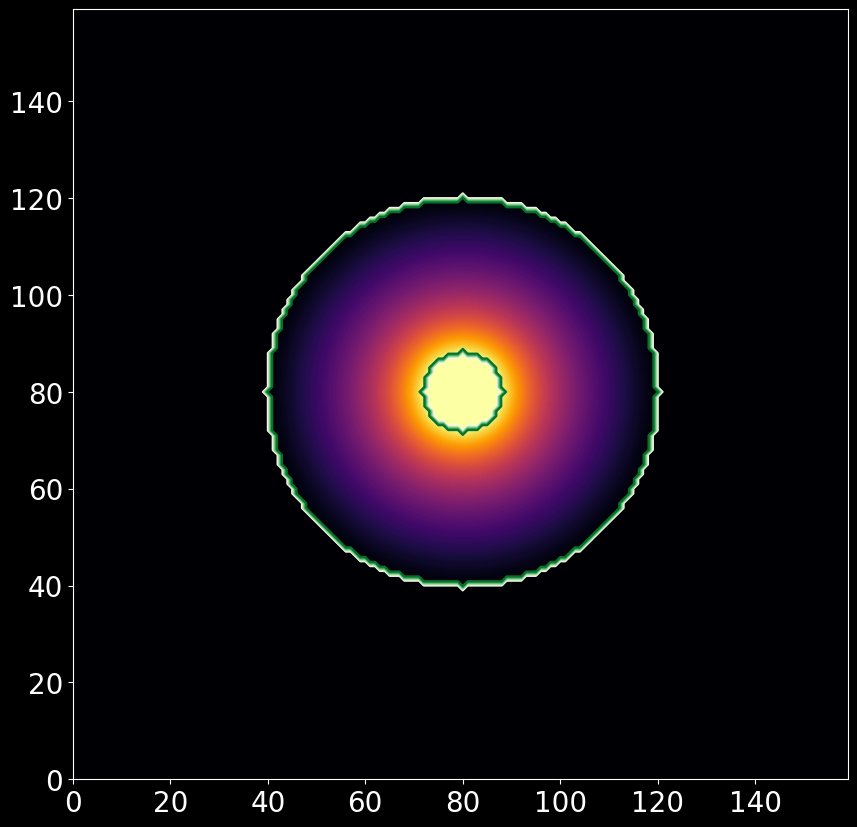

In [211]:
plt.figure(figsize=(10, 10))
plt.contour(sauce_mask, cmap='Greens')
plt.contourf(heat_frames[-1], 150, cmap="inferno", vmin=25, vmax=70)

Text(0, 0.5, 'Temperature, $\\circ$')

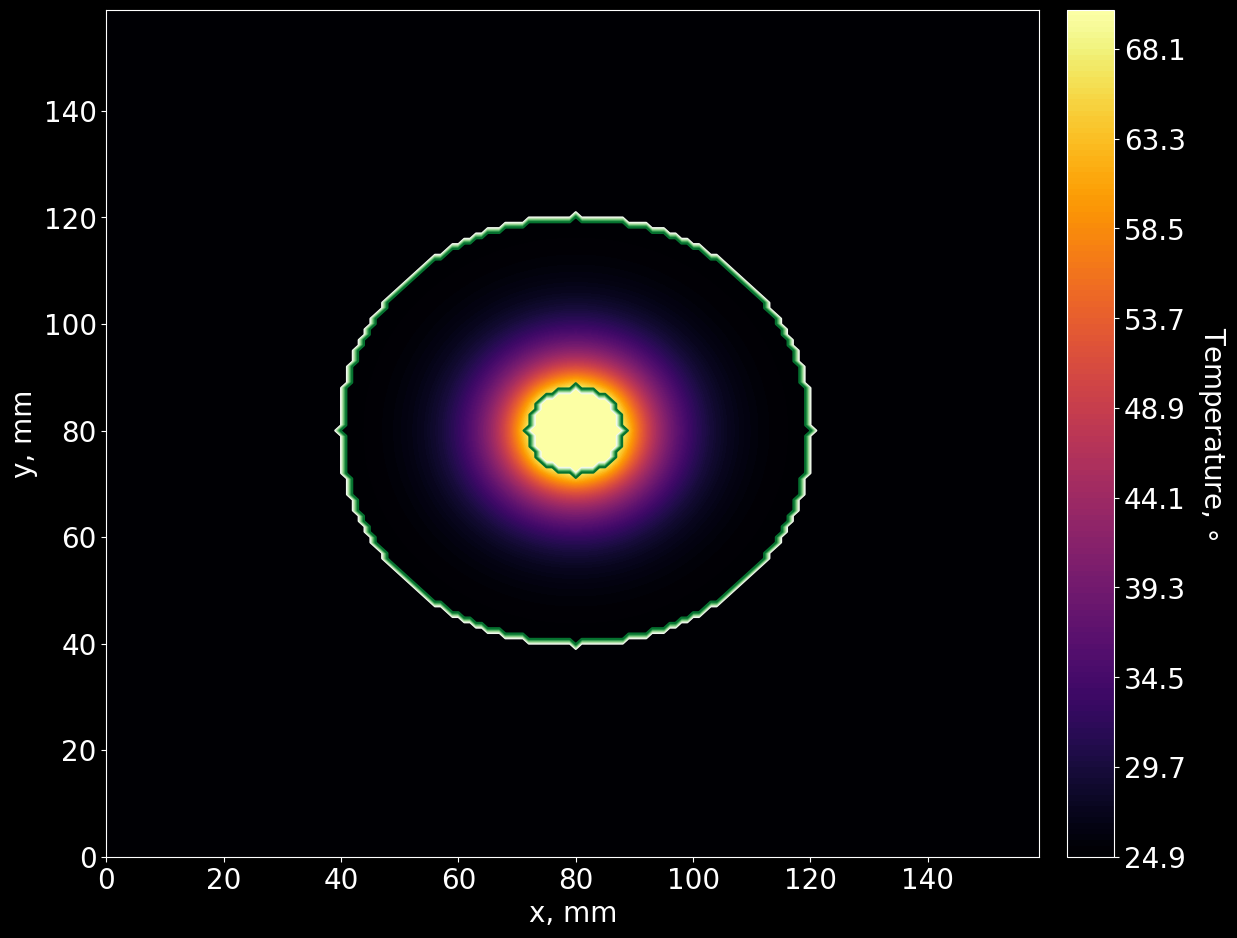

In [212]:
fig, ax = plt.subplots(figsize=(13, 11))
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '3%')

plt.rcParams.update({'font.size' : 20})

ax.contour(sauce_mask, cmap='Greens') #contour bondouries 
cf = ax.contourf(heat_frames[1000], 150, vmin=25, vmax=70, cmap='inferno') #simulation
ax.set_xlabel('x, mm')
ax.set_ylabel('y, mm')
#cax.cla()
cb = plt.colorbar(cf, cax=cax)
cb.ax.set_ylabel(r'Temperature, $\circ$', rotation=270, labelpad=30)

MovieWriter ffmpeg unavailable; using Pillow instead.


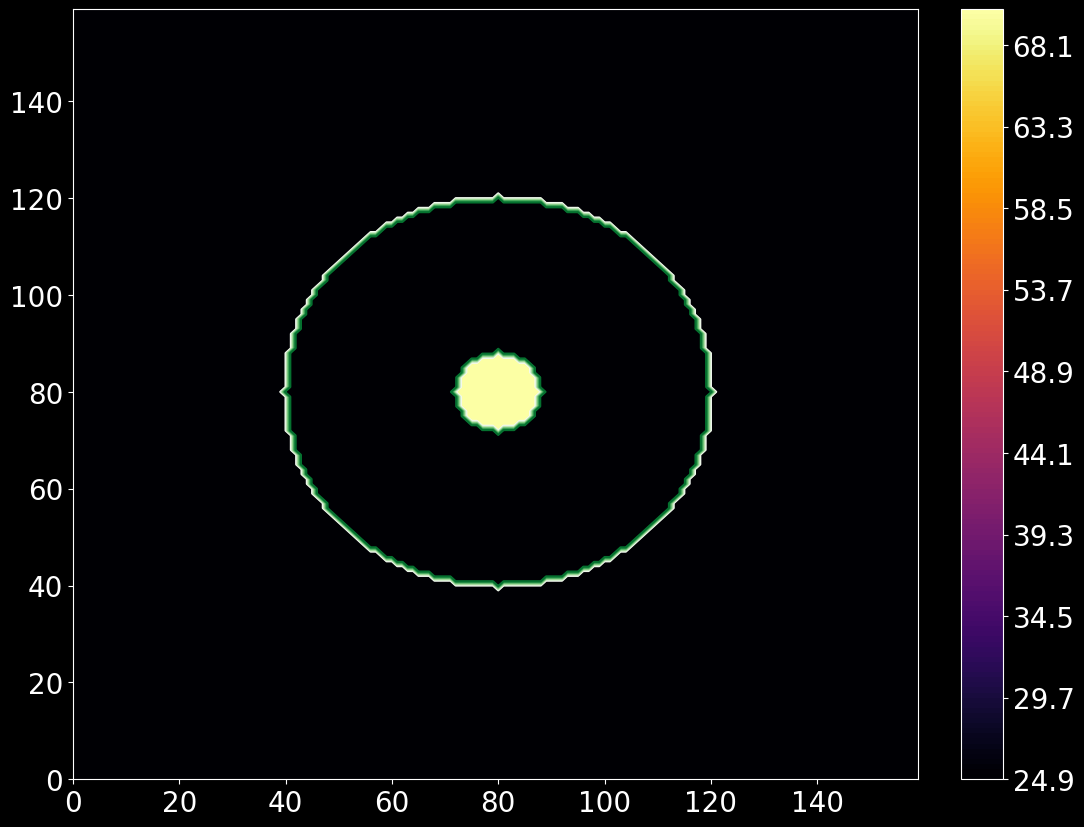

In [213]:
plt.rcParams.update({'font.size' : 20})

fig, ax = plt.subplots(figsize=(12, 10))
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')

def animate(t):
    ax.clear()
    ax.contour(sauce_mask, cmap='Greens') #contour bondouries 
    cf = ax.contourf(heat_frames[10 * t], 150, vmin=25, vmax=70, cmap='inferno') #simulation
    cax.cla()
    fig.colorbar(cf, cax=cax)
    #plt.colorbar()

    return fig,

ani = animation.FuncAnimation(fig, animate, frames=359, interval=25)
ani.save('laser.gif', fps=30)

## Diffusive model + heat dissipations
For simple equation, such as: 
$$\frac{\partial T}{\partial t} = \alpha^2 \Delta T =  \alpha^2 [\frac{\partial^2 T}{\partial x^2} +  \frac{\partial^2 T}{\partial y^2}] + \beta (T-T_0)  $$

Eulier method: 

$$\alpha^2 [\frac{T_{i+1, j}^{(m)} - 2T_{i, j}^{(m)} + T_{i-1, j}^{(m)}}{\Delta x^2} +  \frac{T_{i, j+1}^{(m)} - 2T_{i, j}^{(m)} + T_{i, j-1}^{(m)}}{\Delta y^2}] + \beta (T_{i, j}^{(m)}-T_0) =  \frac{T_{i, j}^{(m+1)} - T_{i, j}^{(m)}}{\Delta t}$$

$$ T_{i, j}^{(m+1)} =  T_{i, j}^{(m)} + \Delta t \alpha^2 [\frac{T_{i+1, j}^{(m)} - 2T_{i, j}^{(m)} + T_{i-1, j}^{(m)}}{\Delta x^2} +  \frac{T_{i, j+1}^{(m)} - 2T_{i, j}^{(m)} + T_{i, j-1}^{(m)}}{\Delta y^2}] + \beta (T_{i, j}^{(m)}-T_0) $$

In [214]:
b = -1.2e-7

In [215]:
heat_frames_newt = np.zeros([times_snapshot, 160, 160])
heat_frames_newt[0] = temperature

In [216]:
import numba 
from numba import jit

@numba.jit("f8[:,:,:](f8[:,:,:], b1[:,:])", nopython=True, nogil=True)
def solve_heat_newtonian(heatmap, sauce_mask):
    current_state  = heatmap[0].copy()
    x_size, y_size = current_state.shape
    current_frame  = 0
    
    for t in range(1, times):
        new_state = current_state.copy()
        for i in range(1, x_size - 1):
            for j in range(1, y_size - 1):
                if sauce_mask[i][j]:
                    new_state[i][j] = current_state[i][j] + a_sauce*dt/dx_size**2 * \
                        (current_state[i+1][j] + current_state[i-1][j] + current_state[i][j+1] + current_state[i][j-1] - 4*current_state[i][j]) + \
                        b * (current_state[i][j] - initial_tempreature)
        current_state = new_state.copy()
        
        if t % frame_iteration == 0:      
            current_frame += 1
            heatmap[current_frame] = current_state

    return heatmap

In [217]:
heat_frames_newt = solve_heat_newtonian(heat_frames_newt, sauce_mask)
heat_frames_newt -= 273.15

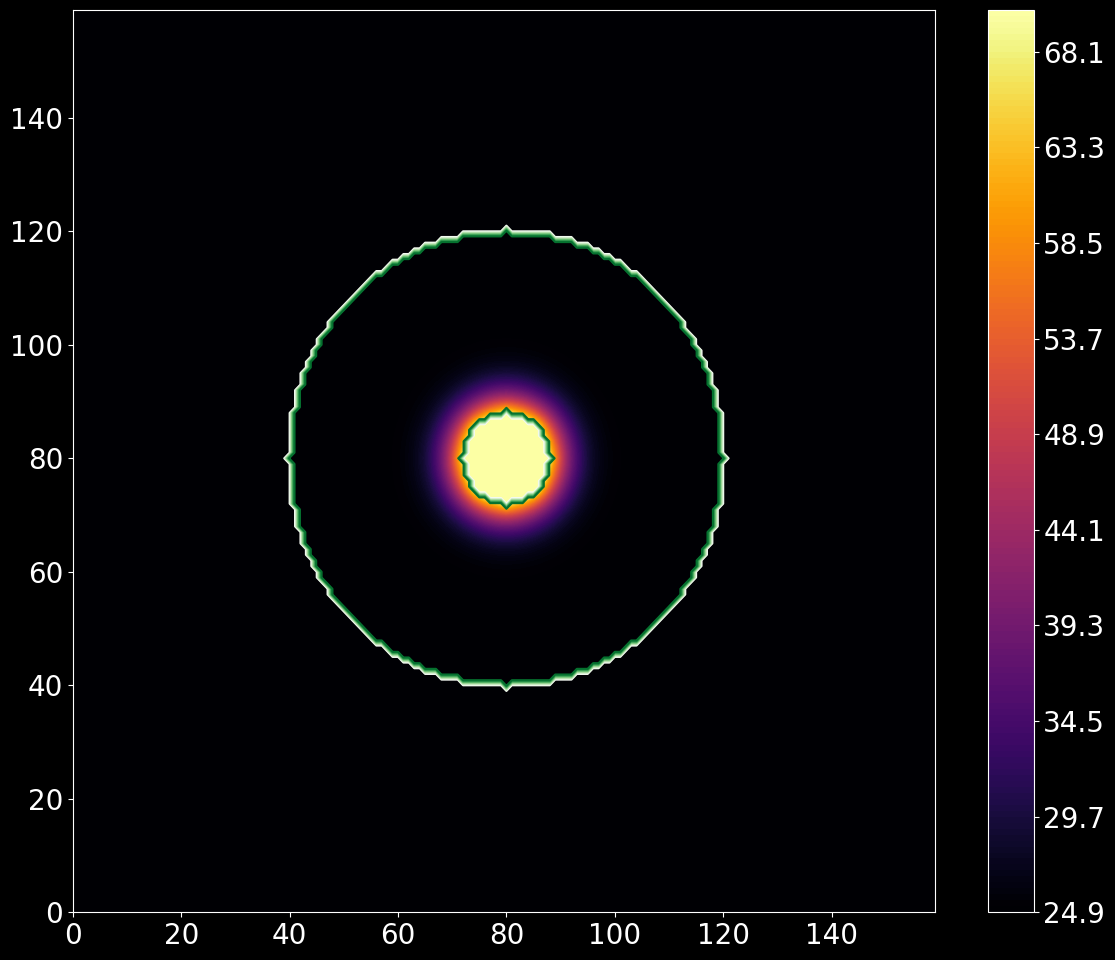

In [218]:
plt.figure(figsize=(12, 10))
plt.contour(sauce_mask, cmap='Greens')
plt.contourf(heat_frames_newt[200], 150, vmin=25, vmax=70, cmap='inferno')
plt.colorbar()
plt.tight_layout()

MovieWriter ffmpeg unavailable; using Pillow instead.


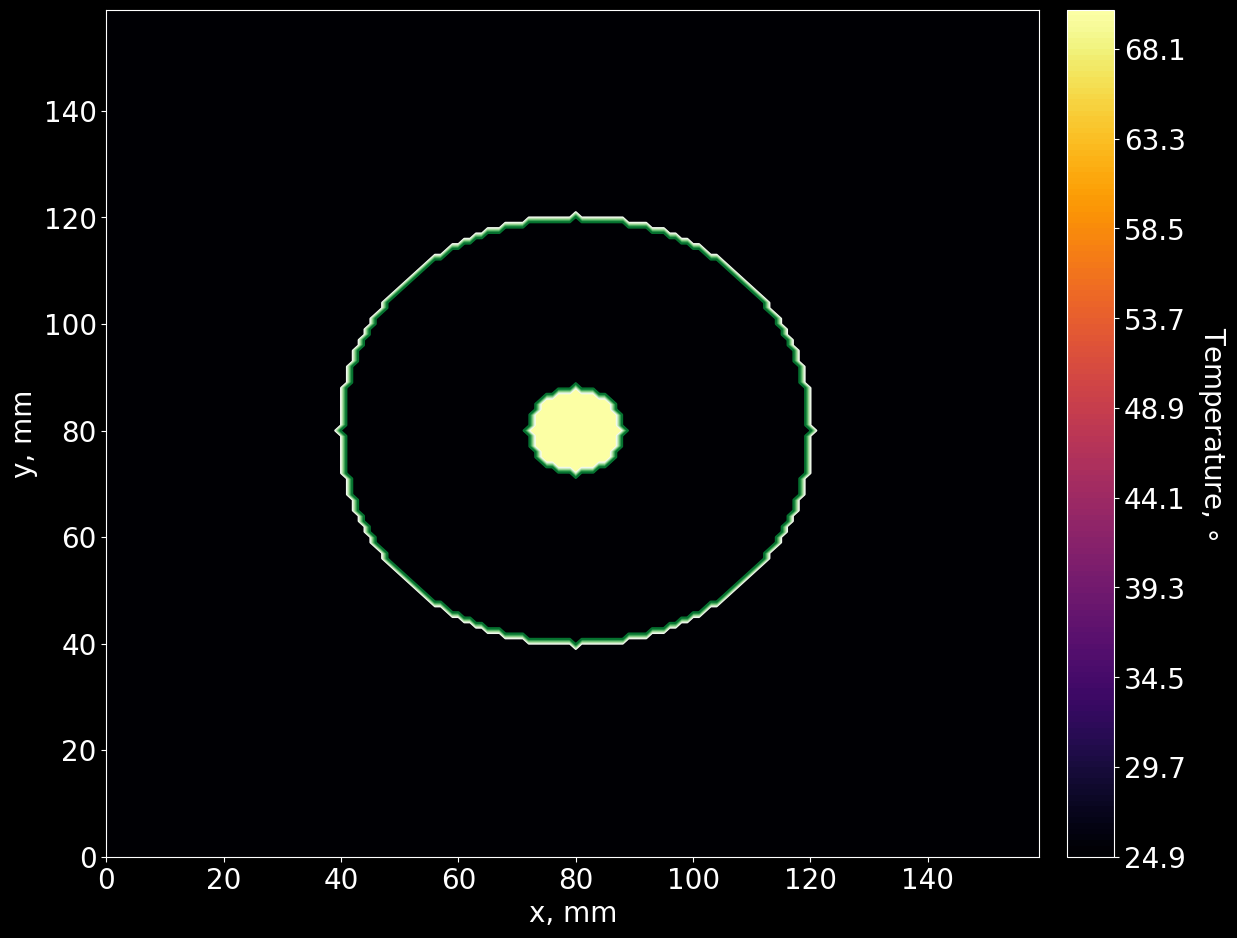

In [219]:
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams.update({'font.size' : 20})

fig, ax = plt.subplots(figsize=(13, 11))
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '3%')

def animate(t):
    ax.clear()
    ax.contour(sauce_mask, cmap='Greens') #contour bondouries 
    cf = ax.contourf(heat_frames_newt[10 * t], 150, vmin=25, vmax=70, cmap='inferno') #simulation
    ax.set_xlabel('x, mm')
    ax.set_ylabel('y, mm')
    cax.cla()
    cb = fig.colorbar(cf, cax=cax)
    cb.ax.set_ylabel(r'Temperature, $\circ$', rotation=270, labelpad=30)
    #plt.colorbar()

    return fig,

ani = animation.FuncAnimation(fig, animate, frames=359, interval=25)
ani.save('laser+diss.gif', fps=30)

In [233]:
heat_frames_newt[-1]

array([[25., 25., 25., ..., 25., 25., 25.],
       [25., 25., 25., ..., 25., 25., 25.],
       [25., 25., 25., ..., 25., 25., 25.],
       ...,
       [25., 25., 25., ..., 25., 25., 25.],
       [25., 25., 25., ..., 25., 25., 25.],
       [25., 25., 25., ..., 25., 25., 25.]])

In [235]:
n_map = heat_frames_newt[-1]
n_map = 1.336 - 1e-3 * (n_map - 20.0)

In [236]:
n_map

array([[1.331, 1.331, 1.331, ..., 1.331, 1.331, 1.331],
       [1.331, 1.331, 1.331, ..., 1.331, 1.331, 1.331],
       [1.331, 1.331, 1.331, ..., 1.331, 1.331, 1.331],
       ...,
       [1.331, 1.331, 1.331, ..., 1.331, 1.331, 1.331],
       [1.331, 1.331, 1.331, ..., 1.331, 1.331, 1.331],
       [1.331, 1.331, 1.331, ..., 1.331, 1.331, 1.331]])

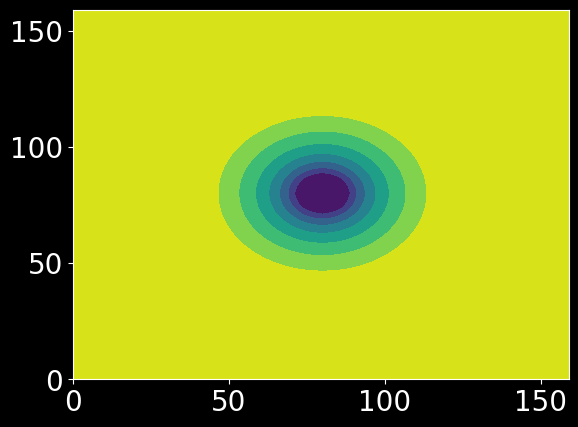

In [237]:
plt.contourf(n_map)

In [240]:
mask_default =  np.ones((160, 160)) - circle_on_array(160, 160, 80, 80, 5/dx_size)
mask_default = mask_default.astype(bool)
n_map[n_map==1.331] = 1

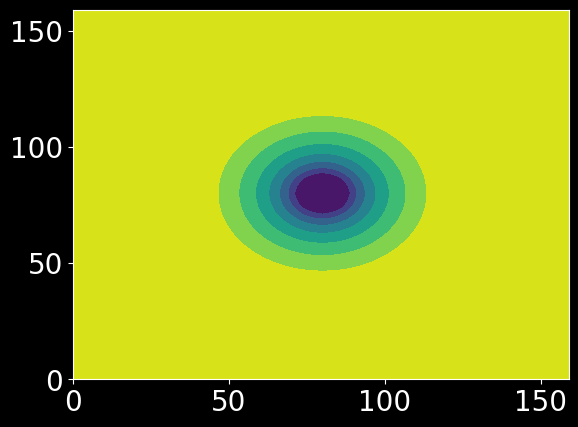

In [241]:
plt.contourf(n_map)

In [242]:
n0 = n_map[80][80]

In [243]:
import numpy as np
import openphoton as op
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

In [525]:
L = 0.02
R = 0.01
wavelength = 532e-9
N = 160
dx = L / N

In [349]:
u0 = op.devices.laser_beam(side_length=L, aperture_radius=R, pixels=N)#.astype('complex128')
u0 = op.rayleigh_sommerfeld.fresnel_approx(u0, L, wavelength, z=0.5)

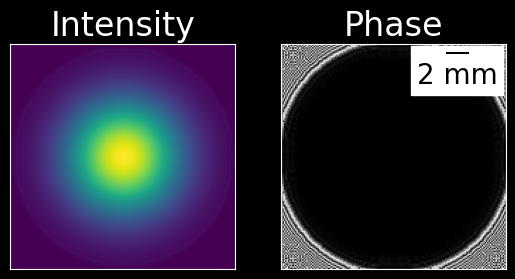

In [351]:
plt.style.use('dark_background')
fig, axis = plt.subplots(1, 2)
intensity = np.abs(u0)**2
phase = np.abs(np.angle(u0))

axis[0].imshow(intensity)
axis[0].set_title("Intensity")
axis[0].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

axis[1].imshow(phase, cmap='gray')
axis[1].set_title("Phase")
axis[1].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

scalebar = ScaleBar(dx)
plt.gca().add_artist(scalebar)
plt.show()

In [614]:
L = 0.013
R = 0.1
wavelength = 532e-9
N = 160
dx = L / N

In [615]:
u0 = op.devices.laser_beam(side_length=L, aperture_radius=R, pixels=N)#.astype('complex128')
u0 = op.rayleigh_sommerfeld.fresnel_approx(u0, L, wavelength, z=0.5)

phase_plane = np.exp(complex(0, 1) *(n_map - n0) *1000)
phase_plane[mask_default] = 0

u0 = np.multiply(u0, phase_plane)

u1 = op.rayleigh_sommerfeld.fresnel_approx(u0, L, wavelength, z=0.9)
#u2 = np.multiply(u1, op.lenses.converging_lens(u1, L, wavelength, 0.093))

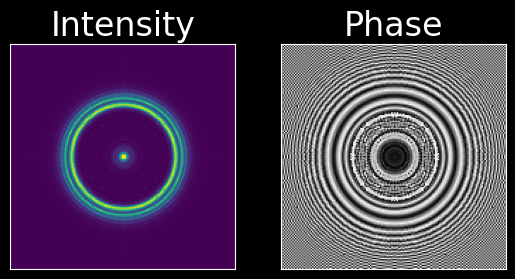

In [616]:
plt.style.use('dark_background')
fig, axis = plt.subplots(1, 2)
intensity = np.abs(u1) ** 2
phase = np.abs(np.angle(u1))

axis[0].imshow(intensity)
axis[0].set_title("Intensity")
axis[0].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

axis[1].imshow(phase, cmap='gray')
axis[1].set_title("Phase")
axis[1].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

#scalebar = ScaleBar(dx)
#plt.gca().add_artist(scalebar)
plt.show()

In [486]:
L = 0.02
R = 0.0005
wavelength = 532e-9
N = 160

In [491]:
u0 = op.devices.laser_beam(side_length=L, aperture_radius=R, pixels=N)#.astype('complex128')
u0 = op.rayleigh_sommerfeld.fresnel_approx(u0, L, wavelength, z=0.03)

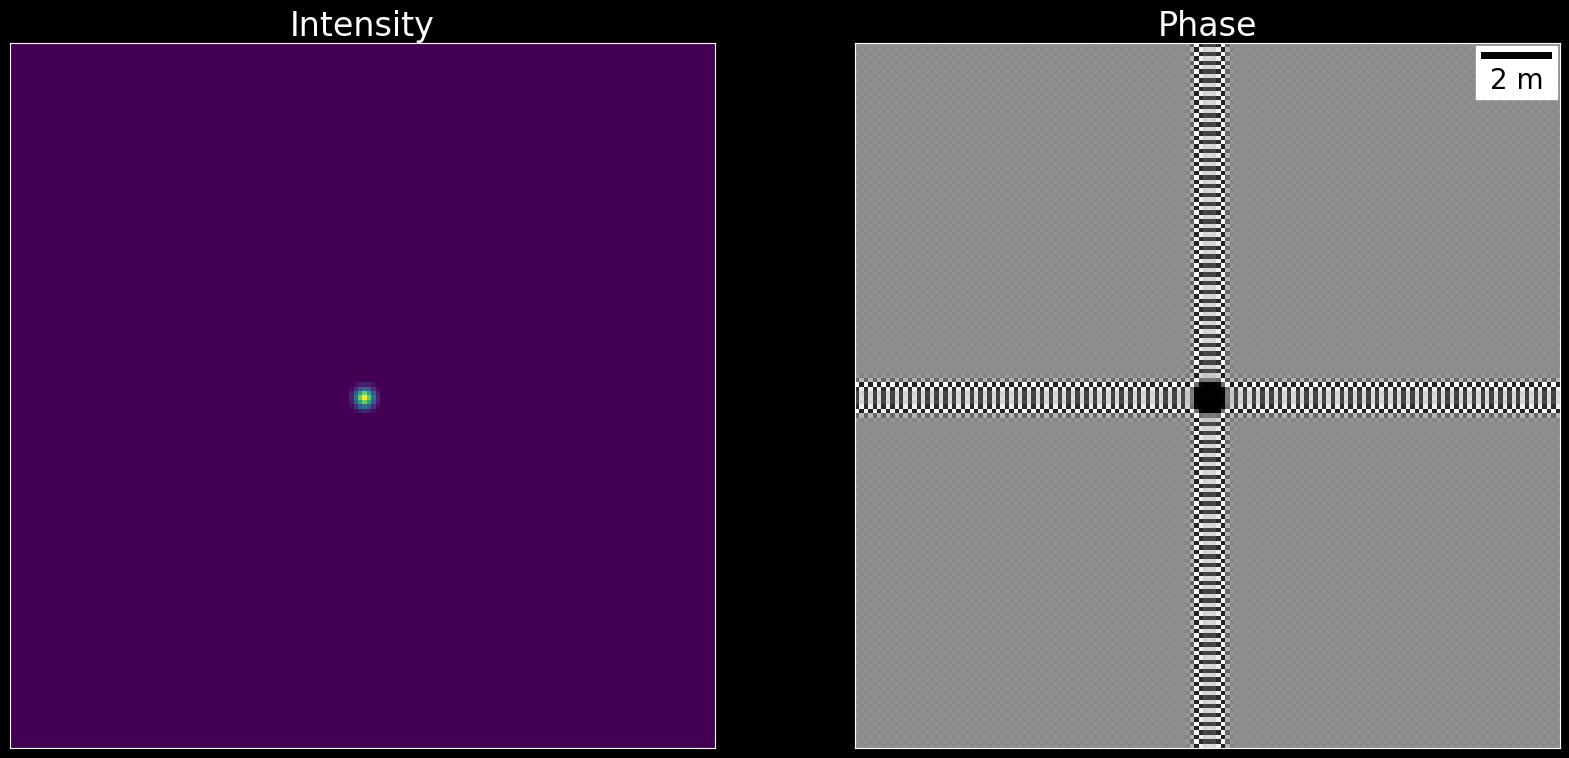

In [492]:
plt.style.use('dark_background')
fig, axis = plt.subplots(1, 2, figsize=(20, 10))
intensity = np.abs(u0)**2
phase = np.abs(np.angle(u0))

axis[0].imshow(intensity)
axis[0].set_title("Intensity")
axis[0].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

axis[1].imshow(phase, cmap='gray')
axis[1].set_title("Phase")
axis[1].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

scalebar = ScaleBar(dx)
plt.gca().add_artist(scalebar)
plt.show()

In [504]:
f = np.pi * 0.6 * 0.002 ** 2 / (2.3 * 1 * 0.01 ** 2)
f

0.0327818363852848

In [521]:
u0 = op.devices.laser_beam(side_length=L, aperture_radius=R, pixels=N)#.astype('complex128')
u0 = op.rayleigh_sommerfeld.fresnel_approx(u0, L, wavelength, z=0.095)

phase_plane = np.exp(complex(0, 1) *(n_map - n0) * 0.001)
phase_plane[mask_default] = 0

u0 = np.multiply(u0, phase_plane)

u1 = op.rayleigh_sommerfeld.fresnel_approx(u0, L, wavelength, z=0.095)

In [604]:
r = 20
u1_out = u1
for i in range(len(u1)):
    for j in range(len(u1[0])):
        if i ** 2 + j ** 2 <= r ** 2:
            u1_out[i][j] = 0
u1_in = u1
for i in range(len(u1)):
    for j in range(len(u1[0])):
        if i ** 2 + j ** 2 > r ** 2:
            u1_out[i][j] = 0

In [612]:
# u2 = wave field after the lens
u2 = np.multiply(u1_in, op.lenses.converging_lens(u1, L, wavelength, f)) + u1_out

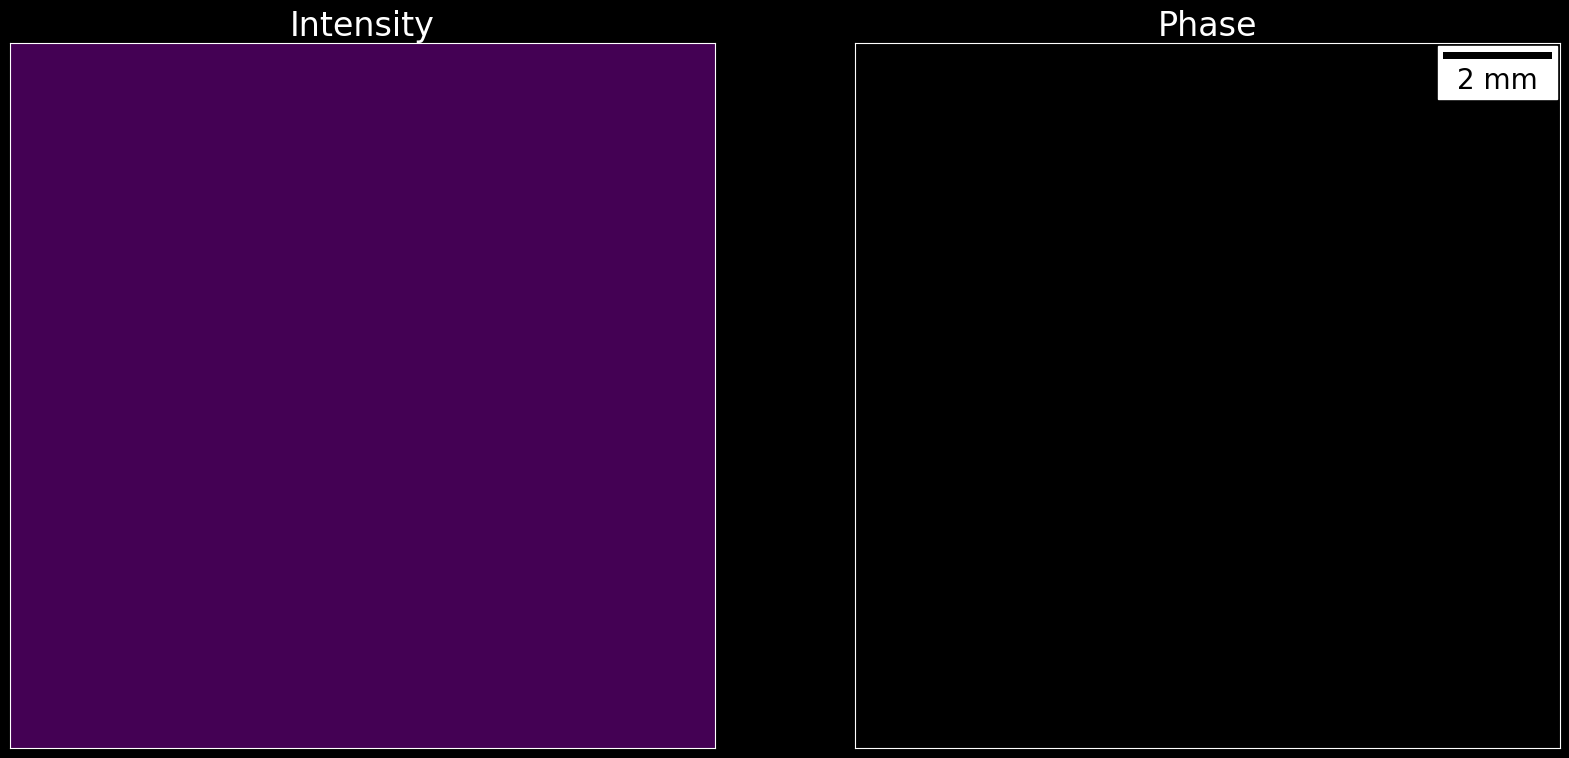

In [611]:
plt.style.use('dark_background')
fig, axis = plt.subplots(1, 2, figsize=(20, 10))
intensity = np.abs(u2) ** 2
phase = np.abs(np.angle(u2))

axis[0].imshow(intensity)
axis[0].set_title("Intensity")
axis[0].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

axis[1].imshow(phase, cmap='gray')
axis[1].set_title("Phase")
axis[1].tick_params(left=False, right=False, labelleft=False, labelbottom=False, bottom=False)

scalebar = ScaleBar(dx)
plt.gca().add_artist(scalebar)
plt.show()

Note: $\omega_H$ - "$1/e^2$ diameter of gaussian beam" - the radius of beam where $I(\omega_H) = 1/e^2 \cdot I(0)$

Such as the heat equation solution is  $ \Delta T(r, t) = \frac{P_H}{4 \pi \kappa} \left[ Ei(-\frac{2r^2}{\omega_H^2}) - Ei(-\frac{2r^2}{\omega_H^2} \tau) \right]$, where $\tau = \frac{1}{1 + t_c / 2t}$ and $t_c = \frac{\omega_H^2}{4D}$ - thermal relaxation time, $D = \frac{\kappa}{\rho} c_p$ - thermal diffusivity

$ \Delta s = l \frac{\partial n}{\partial T} \left ( T(r, t) - T(0, t) \right )$
$ \newline $
$ \Delta \Phi = \frac{\theta}{2} \left[ Ei(-\frac{2r^2}{\omega_H^2} \tau) - Ei(-\frac{2r^2}{\omega_H^2}) - \ln(\tau) \right] $, where $ \theta = \frac{\partial n}{\partial T} \cdot \frac{P_H l}{\kappa \lambda} $

References: 
1. https://www.youtube.com/watch?v=8DrR_tpfg0Q&ab_channel=Mr.PSolver
2. https://www.youtube.com/watch?v=CXOrkQs4WYo&ab_channel=YounesLab
3. https://www.youtube.com/watch?v=JFWqCQHg-Hs&ab_channel=MatiasOrtiz
4. https://mc.manuscriptcentral.com/tqe-ieee